# Отчет анализа стоимости ювелирных изделий у МЮЗ, дата парсинга -  14 апреля 2022

##  Парсинг 
 С сайта https://miuz.ru были спарсены данные ювелирных издели предлагаемых на интернет магазине с фильтром - кольца - основной камнень бриллиант
https://miuz.ru/catalog/rings/filter/stones_main-is-brilliant/ 
Процесс парсинга, реализован в файле ParsingMiuz.ipynb, процесс очистки и расчет прейскуратной стоимости
бриллиантов в файле for_parsing_func.ipynb

Всего колец с фильтром бриллиант на сайте более 4431 изделий, часть данных было отброшено по причинам:
- если изделие содержало другие камни или жемчуг кроме бриллианта
- изделие не могло правильно считаться парсером
- характеристики бриллиантов содержало ошибки
- были использованы фантазийные по цвету бриллианты (возможно синтетика)

В результате получен датасет с ювелирными изделиями со следующими данными (параметрами):
- Наименование(кольца только с бриллиантами  в количестве 1980 изделий), 
- Артикул,
- Ссылка на карточку с изделием (кликабельная ссылка)
- Стоимость изделия в рублях с учетом скидки (цены от 10 тыс.руб до 981 тыс.руб, на общую сумму 223,3 млн рублей, средняя стоимость 113 тыс.руб),
- масса изделия в граммах (от 0,86 до 20 грамм, общая масса 5703 грамма средний вес 2,88 грамма),
- проба золота (585 проба - 1807 шт, 750 - 140 шт, 375 - 33 шт),
- штук бриллиантов (всего 52748 штук, в среднем на изделие 26 бриллиантов)
- карат бриллиантов (всего 639 карат средняя масса камня 0,012 карат)
- прейскурантная стоимость бриллиантов в долларах (всего 289 тыс долларов, со средней прейскурантной стоимостью 452 доллара за карат)
Датасет приведен в файле 'jewels/muiz04-2022/_брилл_суммированы_mius140422_0-4431.xlsx'


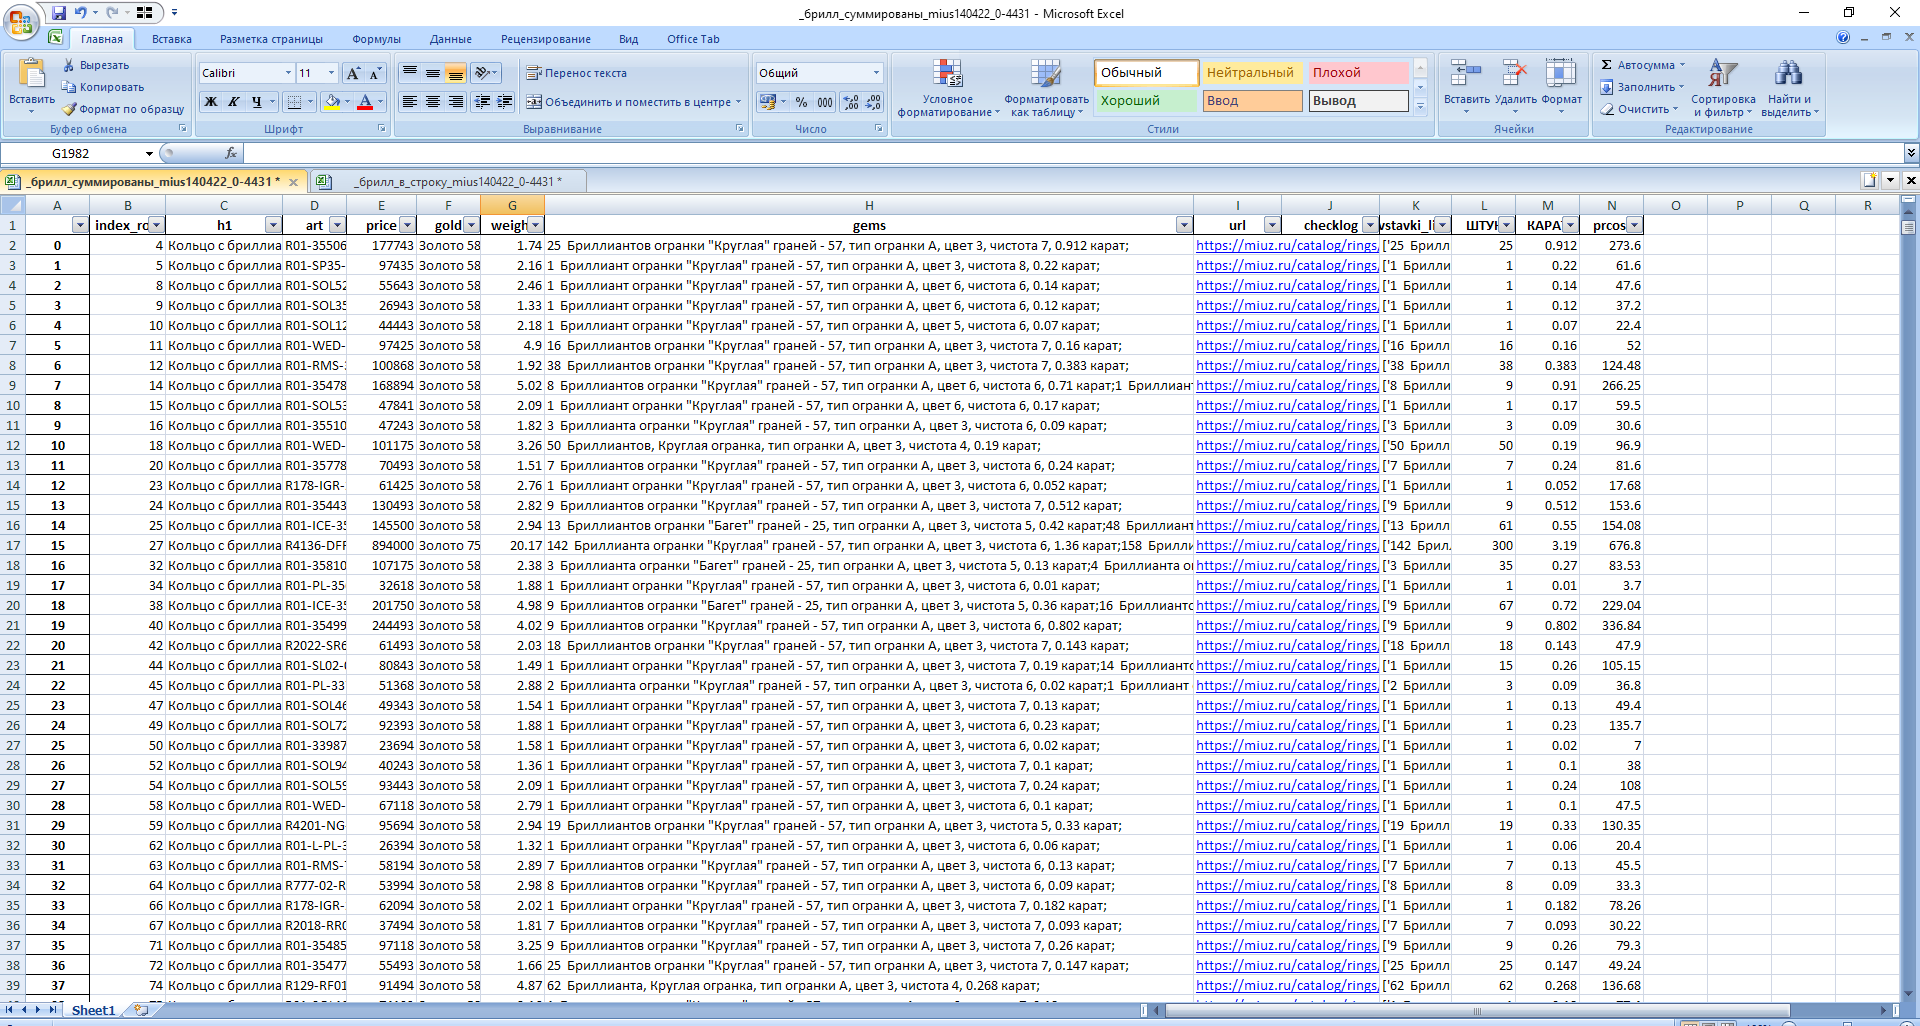

##  Анализ датасета МЮЗ, визуализация, определение коэфициентов
###  Считывание данных с файла
Для этого устанавливаем необходимые модули.
 - загружаем данные с файла 
 #- откыдываем изделия дороже 500т руб, 
 - оставляем изделия пробы 585,
 #- отбрасываем изделия с бриллиантами по прейскуранту свыше 3000 долларов
 - оставлены поля price : цена изделя, weight: масса изделия в граммах, prcost: прейскурант в долларах

In [11]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
filenamemiuz = 'jewels/muiz04-2022/_брилл_суммированы_mius140422_0-4431.xlsx'#'jewels/miuz/_брилл_суммированы_mius161121_0-3178.xlsx'

In [12]:
filenamemiuz

'jewels/muiz04-2022/_брилл_суммированы_mius140422_0-4431.xlsx'

In [13]:
raw = pd.read_excel(filenamemiuz,sheet_name=0)

In [29]:
data = raw.loc[(raw.gold.str.contains('585') ),['price','weight','prcost']].loc[(raw.price<500000),:].loc[(raw.prcost<3000),:]
data.head()

,price,weight,prcost
0,177743,1.74,273.60
1,97435,2.16,61.60
2,55643,2.46,47.60
3,26943,1.33,37.20
4,44443,2.18,22.40


In [54]:
print(f'''После урезания получен датасет с {len(data)} данными 
общая масса изделий {round(data.sum()['weight']/1000,2)} кг на сумму {round(data.sum()['price']/1000000)} млн рублей 
с прейскурантной стоимостью  {round(data.sum()['prcost']/1000)}  тыс долл''') 

После урезания получен датасет с 1780 данными 
общая масса изделий 4.73 кг на сумму 149 млн рублей 
с прейскурантной стоимостью  182  тыс долл


In [31]:
#сумма датасета
data.describe()

,price,weight,prcost
count,1780.00,1780.00,1780.00
mean,83594.21,2.66,102.45
std,71931.27,1.12,141.09
min,14694.00,0.89,1.60
25%,42294.00,1.91,32.19
50%,62094.00,2.38,59.91
75%,94268.75,3.14,111.28
max,494994.00,9.50,1484.00


###  Визуализиация данных
Построим облако точек в трехмерной плоскости
- х вес золота в граммах
- y стоимость прейскурантная бриллиантов
- z стоимость изделия в тысячах рублей

Если покрутить график, то видно что точки стремятся к плоскости



In [33]:
%matplotlib notebook

<IPython.core.display.Javascript object>


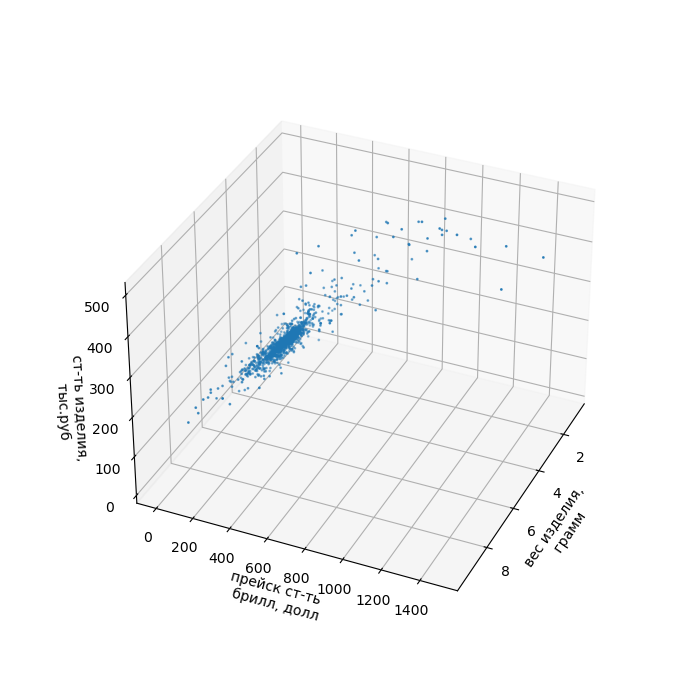

In [34]:
#
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection = "3d")
ax.scatter3D(data.weight,data.prcost,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('вес изделия, \n грамм')
ax.set_ylabel('прейск ст-ть \n брилл, долл')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(45,0)
#todo 3 projection need

### Подготовка данных для определения коэффициентов  

Для того чтобы полученные коэффициенты имели интерпретируемый смысл, предлагается прейскурантную стоимость бриллиантов перевести в рубли, граммы золота перевести в биржевую стоимость золота, данного веса изделия в рублях. 

In [35]:
#Курс доллара и биржевая цена золота на 03-12-2021
#dollar_rate = 73.66
#gold_rate = 4191.05
#Курс доллара и биржевая цена золота на 19-04-2022
dollar_rate = 80.36
gold_rate = 5015.06
data['prcost_rub'] = data.prcost*dollar_rate
data['gold_rub'] = data.weight*0.585*gold_rate
pd.options.display.float_format ="{:.2f}".format
data.head()

,price,weight,prcost,prcost_rub,gold_rub
0,177743,1.74,273.60,21986.50,5104.83
1,97435,2.16,61.60,4950.18,6337.03
2,55643,2.46,47.60,3825.14,7217.17
3,26943,1.33,37.20,2989.39,3901.97
4,44443,2.18,22.40,1800.06,6395.71


<IPython.core.display.Javascript object>


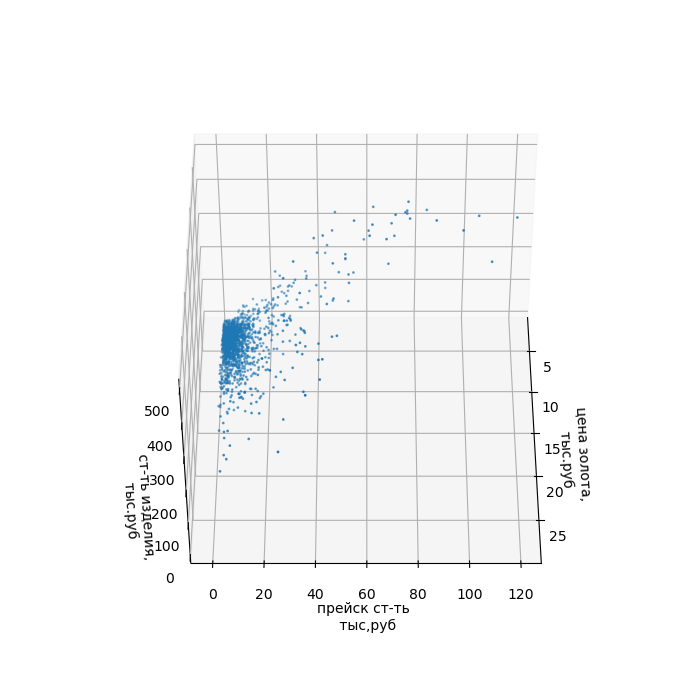

In [36]:
#новое графическое представление будеть иметь вид
fig2 = plt.figure(figsize=(7,7))
ax = plt.gca(projection = "3d")
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='#1f77b4')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(45,0)

Цена ювелирного изделия в первом приближении формируется линейной зависимостью, если обозначить за Z - цену издели, X - масса золота, Y - прейскурнтная стоимость бриллианов то можно записть закономерностю вида:

$$ Z = f(X,Y) = НДС*СКИДКА*НАЦЕНКА*\\(ПРОБА*БИРЖЕВАЯСТОИМОСТ*НАЦЕНКАЗОЛОТА*СЛОЖНОСТЬ*X\\ 
+НАЦЕНКАПРЕЙСКУРАНТ*СЛОЖНОСТЬ*Y+НАЦЕНКАБЕЗДКДМ) $$
можно раскрыть скобки, перемножить множители и мы получим уравнение вида:
$$ Z = A*X+B*Y+C $$
линейное уравнение такого вида в трехмерной плоскости является плоскостью, поэтому необходимо усредненную плоскость и найти эти три коэффициента.

###  Вычисление коэффициентов усредненой по облаку данных плоскости  

Для этого мы устанавливаем модуль отвечающий за расчеты линейной алгебры, и загружаем наши данные для расчета коэффициентов, и получаем коэффициенты



In [37]:
from sklearn import linear_model
#подготовка данных 
miuz = linear_model.LinearRegression()
X_train = data.iloc[:,:].loc[:,['gold_rub','prcost_rub']].to_numpy()
Y_train = data.iloc[:,:].loc[:,'price'].to_numpy()
miuz.fit(X_train,Y_train)
A,B = miuz.coef_
C =  miuz.intercept_
A,B,C

(5.1263482267010145, 5.436369408615513, -1152.3962490867125)

### Визуальная проверка полученных коэффициентов

In [38]:
#проверка
data['predict'] = miuz.predict(X_train)
data['bycoef'] = data.gold_rub*miuz.coef_[0] + data.prcost_rub*miuz.coef_[1]+miuz.intercept_
data['diff'] = data.predict-data.bycoef
data.head()

,price,weight,prcost,prcost_rub,gold_rub,predict,bycoef,diff
0,177743,1.74,273.60,21986.50,5104.83,144543.45,144543.45,0.00
1,97435,2.16,61.60,4950.18,6337.03,58244.41,58244.41,0.00
2,55643,2.46,47.60,3825.14,7217.17,56640.20,56640.20,0.00
3,26943,1.33,37.20,2989.39,3901.97,35101.89,35101.89,0.00
4,44443,2.18,22.40,1800.06,6395.71,41420.03,41420.03,0.00


Усредненная по нашим данным плоскость и коэффициенты посчитаны модулем по методу наименьних квадратов, постороим на плоскость построенной плоскости для проверки

<IPython.core.display.Javascript object>


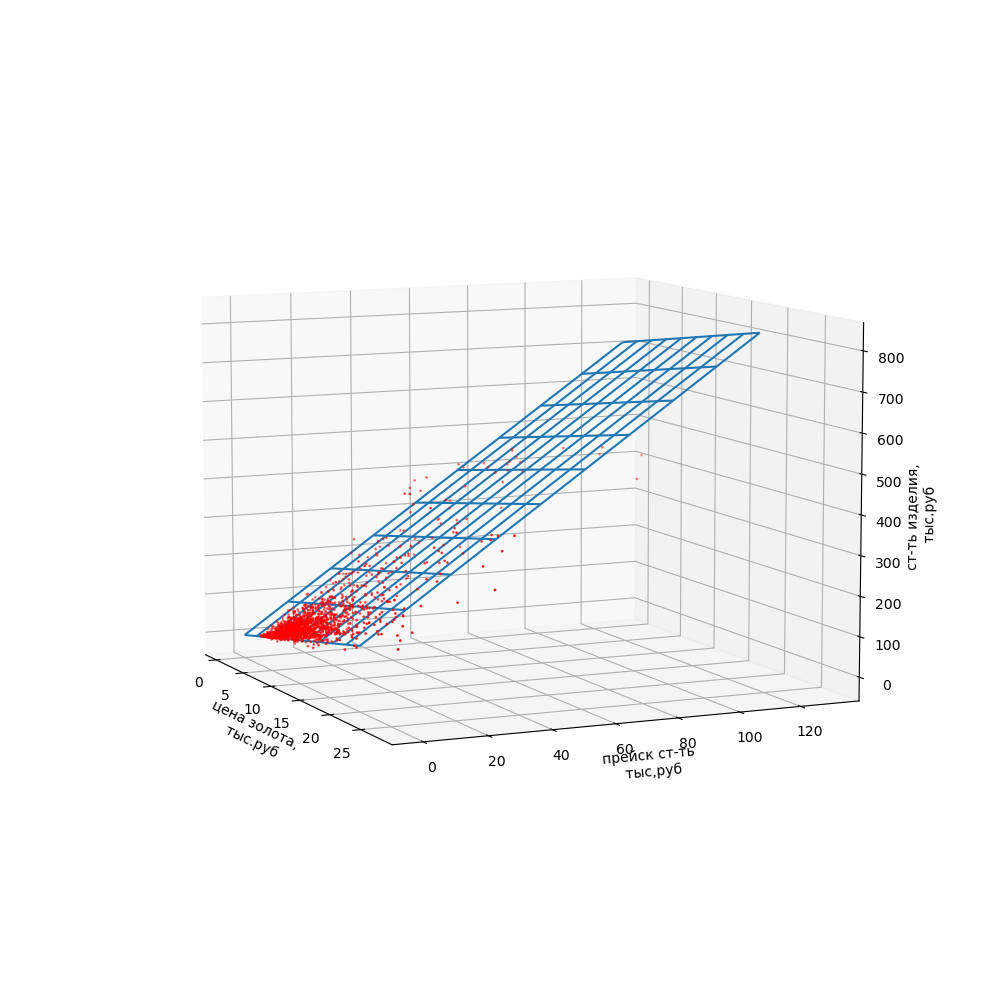

Text(0.5, 0, 'ст-ть изделия,\n тыс.руб')

In [39]:
x_val = np.linspace(0,20000,10)# np.arange(0, 20000,5000)
y_val = np.linspace(0,130000,10)
xx,yy = np.meshgrid(x_val,y_val)
zz = A*xx + B*yy + C/1000
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
#ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.predict/1000,s=1,c='red')
#ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.bycoef/1000,s=1,c='green')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
#ax.plot_surface(xx/1000, yy/1000, zz/1000)

<IPython.core.display.Javascript object>


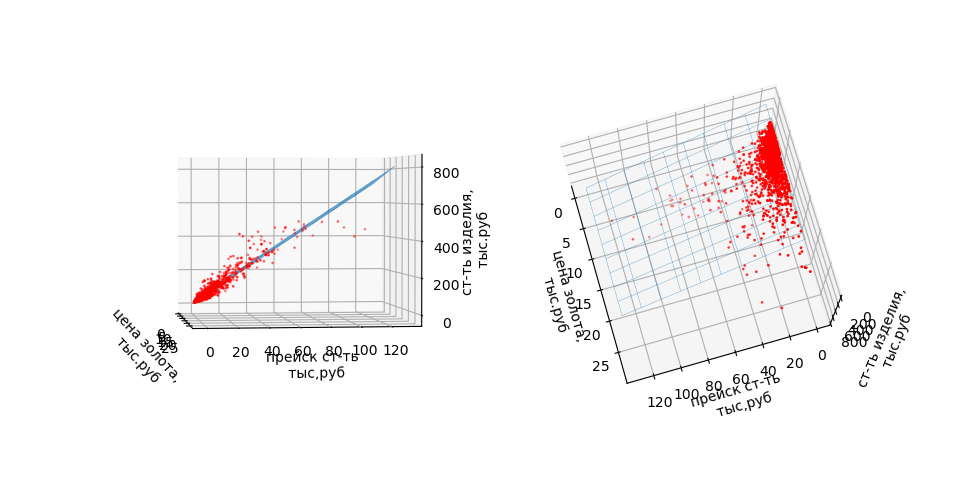

In [40]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000, linewidth=0.2 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(-7,4)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_wireframe(xx/1000, yy/1000, zz/1000, linewidth=0.2 )
ax.scatter3D(data.gold_rub/1000,data.prcost_rub/1000,data.price/1000,s=1,c='red')
ax.set_xlabel('цена золота, \n тыс.руб')
ax.set_ylabel('прейск ст-ть \n тыс,руб')
ax.set_zlabel('ст-ть изделия,\n тыс.руб')
ax.view_init(-66,-166)


# Выводы 
Реализованная модель анализа цен ювелирных изделий с бриллиантами позволяет получить усредненную информацию по ценообразованию.
В анализируемой партии изделий получены следующие коэффициенты цены изделия  

In [68]:
print(f'''                                            A = {A:2.2f} 
                                            B = {B:2.2f} 
                                            C = {C:2.2f}''')

                                            A = 5.13 
                                            B = 5.44 
                                            C = -1152.40


где 
формула - $$ Z = A*X+B*Y+C $$
Z - стоимость изделия в рублях со всеми накрутками с учетом ндс и скидки
X - биржевая стоимость золота, данного веса изделия в рублях
Y - прейскурантная стоимость бриллиантов в рублях
С - наценка в рублях не зависящая от граммов изделия и вставок

Для сравнения в прошлом анализе, подобной партии МЮЗ в (ноябрь 2021) были получены следующие коэффициенты:

$$А = 3.3$$
$$В = 4.0$$
$$С = 2205$$

